#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [25]:
from typing import Callable, List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random

In [26]:
class Function:

    @staticmethod
    def f(x1, x2):
        return 1.5 - np.exp(-(x1 ** 2) - (x2 ** 2)) - 0.5 * np.exp(-((x1 - 1) ** 2) - ((x2 + 2) ** 2))

In [27]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [28]:
class Chromosome:
  def __init__(self, length, array=None):
    """
    Initialize Chromosome with a binary gene array.
    If no array is provided, it generates a random binary vector of given length.
    """
    self.length = length
    self.array = array if array is not None else [random.randint(0, 1) for _ in range(length)]

  def decode(self, lower_bound, upper_bound, aoi):
    """
    Decode binary vector to a real number within the specified range

    @params
    - lower_bound: Starting index of the binary segment.
    - upper_bound: Ending index of the binary segment.
    - aoi: An two element array representing the range of the decoded real number.

    @returns
    - A real value corresponding to the binary segment, normalized withing specified range.
    """

    bin_vec = self.array[lower_bound:upper_bound + 1]
    dec_val = sum(val * (2 ** idx) for idx, val in enumerate(reversed(bin_vec)))

    min_val, max_val = 0, (2 ** len(bin_vec)) - 1
    return min_max_norm(dec_val, min_val, max_val, *aoi)

  def mutation(self, probability):
    """
    Mutate the gene by flipping the bit with the given probability.

    @params
    - probability: Probability of flipping the bit of the gene.
    """

    if random.random() < probability:
      idx = random.randint(0, len(self.array) - 1)
      self.array[idx] = 0 if self.array[idx] == 1 else 1

  def crossover(self, other):
    """
    Perform one-point crossover with another Chromosome object.

    @params
    - other: Other Chromosome object to crossover with.

    @returns
    - Two Chromosome objects resulting from the crossover.
    """

    assert isinstance(other, Chromosome), "You can only crossover with other Chromosome object."

    rand_idx = random.randint(0, len(self.array) - 1)

    first_child_arr = self.array[:rand_idx] + other.array[rand_idx:]
    second_child_arr = other.array[:rand_idx] + self.array[rand_idx:]

    return Chromosome(self.length, first_child_arr), Chromosome(self.length, second_child_arr)

In [36]:
class GeneticAlgorithm:
  """
  Class implementing genetic algorithm to find the minimum of the given function.
  """

  def __init__(self,
               chromosome_length: int,
               obj_func_num_args: int,
               objective_function: Callable[..., float],
               aoi: List[float],
               population_size: int = 1000,
               tournament_size: int = 2,
               mutation_probability: float = 0.05,
               crossover_probability: float = 0.8,
               num_steps: int = 30
               ):

    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"

    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args

    self.bits_per_arg = int(chromosome_length / obj_func_num_args)

    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

    self.population = [Chromosome(self.chromosome_lengths) for _ in range(population_size)]

  def eval_objective_func(self, chromosome) -> Dict[Tuple[float, ...], float]:
    """
    Evaluate objective function for a decoded chromosome

    @params
    - chromosome: Chromosome object

    @returns
    - Dictionary of decoded arguments as a key and value of objective function with decoded args as a value
    """

    assert isinstance(chromosome, Chromosome), "You can only pass Chromosome object."

    decoded_args = []
    for i in range(self.obj_func_num_args):
      start_idx = i * self.bits_per_arg
      end_idx = (i + 1) * self.bits_per_arg

      decoded_args.append(
        chromosome.decode(start_idx, end_idx, self.aoi)
      )

    value = self.objective_function(*decoded_args)

    return {tuple(decoded_args): value}

  def tournament_selection(self):
    """
    Perform tournament selection

    @returns
    - Minimum value of the objective function from sampled population
    """
    sample = random.sample(self.population, self.tournament_size)

    sample.sort(key=lambda chromosome: next(iter(self.eval_objective_func(chromosome).values())))

    return sample[0]

  def reproduce(self, parents):
    """
    Create a new population by applying crossover and mutation

    @params
    - parents: Iterable containing two Chromosome objects

    """

    new_population: list = []
    for parent1, parent2 in parents:

      if random.random() < self.crossover_probability:
        child1, child2 = parent1.crossover(parent2)

      else: child1, child2 = parent1, parent2

      child1.mutation(self.mutation_probability)
      child2.mutation(self.mutation_probability)

      new_population.extend([child1, child2])

      if len(new_population) >= len(self.population): # adjust to pop size
        break

    self.population = new_population[:len(self.population)]   # trim to original size

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    """
    Run genetic algorithm for the specified number of generations
    """

    trace = []

    for generation in range(self.num_steps):

      best_chromosome = min(self.population, key=lambda chromosome:
            next(iter(self.eval_objective_func(chromosome).values()))
      )

      result = self.eval_objective_func(best_chromosome)
      best_coded_args = next(iter(result.keys()))
      best_value = next(iter(result.values()))

      trace.append((best_coded_args[0], best_coded_args[1]))
      print(f"Generation {generation}: Best solution = {best_coded_args}, Objective value = {best_value}")

      num_parents = len(self.population) // 2
      parents = [(self.tournament_selection(), self.tournament_selection()) for _ in range(num_parents)]

      # if num_parents is uneven, add new parent
      if len(self.population) % 2 == 1:
          parents.append((self.tournament_selection(), self.tournament_selection()))

      self.reproduce(parents)

    self.plot_func(trace)

Generation 0: Best solution = (0.006979475696134187, 0.005715569595101595), Objective value = 0.4967425376745983
Generation 1: Best solution = (0.00883899471808819, 0.0023713751085137004), Objective value = 0.4966873450606186
Generation 2: Best solution = (0.006979475696105766, 0.005246825984202528), Objective value = 0.49673111622570526
Generation 3: Best solution = (0.006979475696134187, 0.005228289907466738), Objective value = 0.496730673392344
Generation 4: Best solution = (0.006979475696134187, 0.005228289907182299), Objective value = 0.4967306733923373
Generation 5: Best solution = (0.0010264451798316838, 0.0009499070287732349), Objective value = 0.4966388685662024
Generation 6: Best solution = (0.005564921570339323, 0.0008983990089697313), Objective value = 0.4966374239992793
Generation 7: Best solution = (0.005564921570339323, 0.000898399008969731), Objective value = 0.4966374239992793
Generation 8: Best solution = (0.003750329288240864, 0.00085044476183513), Objective value = 

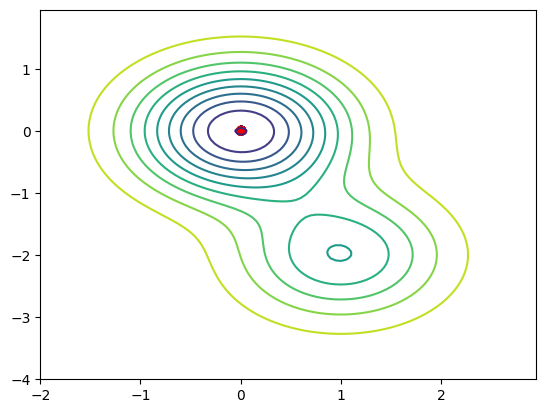

In [34]:
genetic_algorithm = GeneticAlgorithm(128, 2, Function.f, [0, 1])
genetic_algorithm.run()

# Wnioski
Algorytm przy aoi = [0, -1] utknął w minimum lokalnym

Generation 0: Best solution = (0.9254228528380963, 1.2955779411869273), Objective value = 1.4207231606060484
Generation 1: Best solution = (0.9254228528380963, 1.2955779411869273), Objective value = 1.4207231606060484
Generation 2: Best solution = (0.9254228528380963, 1.2955779411869273), Objective value = 1.4207231606060484
Generation 3: Best solution = (0.9254228528380963, 1.2955705623129106), Objective value = 1.4207216445558235
Generation 4: Best solution = (1.7672797200389496, -1.0115247195096586), Objective value = 1.3797194334584957
Generation 5: Best solution = (1.7672797200389496, -1.0115247195096657), Objective value = 1.3797194334584943
Generation 6: Best solution = (-0.06824968274609944, -1.093063050820838), Objective value = 1.1284688701669963
Generation 7: Best solution = (0.04292316767183735, -1.0925904096586976), Objective value = 1.1096625586106525
Generation 8: Best solution = (0.042923211465534905, -1.0115247195097155), Objective value = 1.0659087225051107
Generation

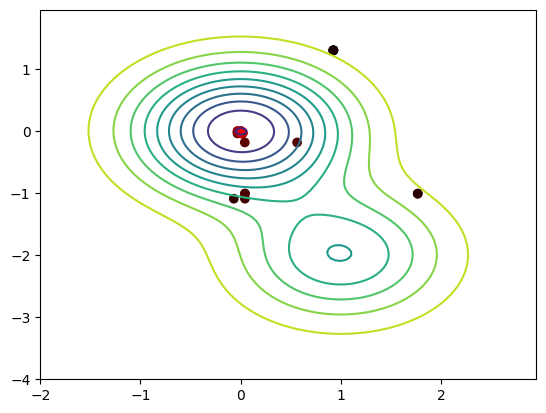

In [32]:
genetic_algorithm = GeneticAlgorithm(128, 2, Function.f, [-50, 50])
genetic_algorithm.run()

Generation 0: Best solution = (0.8095651834397017, -1.0456699801663802), Objective value = 1.1320718212623508
Generation 1: Best solution = (0.2989337591550836, -1.1925754550794352), Objective value = 1.1200804313112165
Generation 2: Best solution = (0.8095651825922303, -0.3235058123285981), Objective value = 1.0033457843450315
Generation 3: Best solution = (0.2989337591550836, -0.41132545512338226), Objective value = 0.7033160116820987
Generation 4: Best solution = (0.2989337591587571, 0.09279982999935754), Objective value = 0.5894951194375999
Generation 5: Best solution = (-0.2434956002781874, -0.053269915937576684), Objective value = 0.5578297627663736
Generation 6: Best solution = (-0.020462938642999973, 0.09279982936088516), Objective value = 0.5067788708260283
Generation 7: Best solution = (-0.032721385534586034, 0.07188492495703258), Objective value = 0.50386642905541
Generation 8: Best solution = (-0.020390599681299193, 0.04152709175235714), Objective value = 0.499404499675615


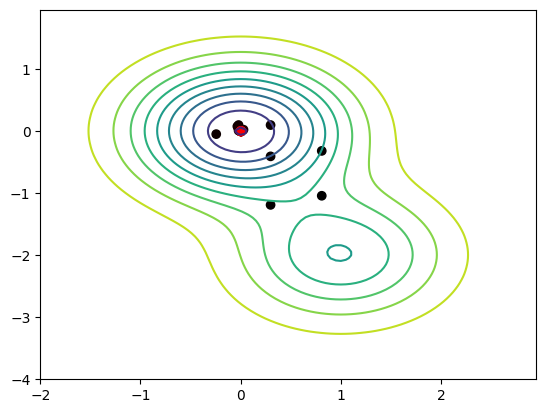

In [29]:
# Greater pop size and more generations

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    population_size=2000,
    tournament_size=5,
    num_steps=100
)
genetic_algorithm.run()


# Wnioski
Algorytm znalazł minimum globalne z dużą dokładnością przy dużej populacji i dużej liczbie pokoleń, lecz
wykonywanie algorytmu zajęło prawię minutę, co przekłada się na dużą złożoność obliczeniową.

Generation 0: Best solution = (31.833351368110556, 14.488504464537854), Objective value = 1.5
Generation 1: Best solution = (-9.692306869548403, -20.27816161292104), Objective value = 1.5
Generation 2: Best solution = (-40.16405950141122, 5.317004646497729), Objective value = 1.5
Generation 3: Best solution = (39.49124136406853, -9.015246603478118), Objective value = 1.5
Generation 4: Best solution = (-35.84388936249328, 39.49598418988228), Objective value = 1.5
Generation 5: Best solution = (47.2168728179516, -20.2781661399639), Objective value = 1.5
Generation 6: Best solution = (-23.041336343319774, 39.49636565960884), Objective value = 1.5
Generation 7: Best solution = (-9.013993354254218, 45.604535022466465), Objective value = 1.5
Generation 8: Best solution = (-23.04186441421703, -30.344094281029456), Objective value = 1.5
Generation 9: Best solution = (-39.44498162035148, 39.496365659947045), Objective value = 1.5


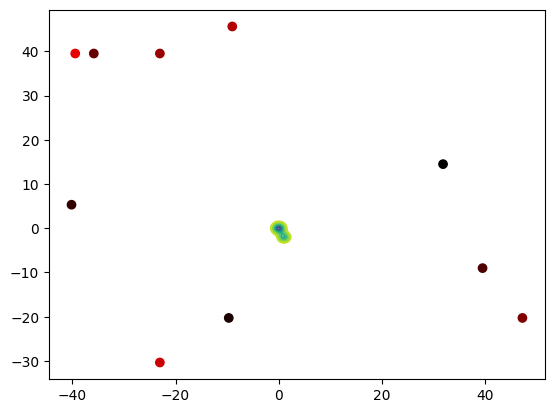

In [30]:
# Smaller pop size and less generations

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    population_size=50,
    num_steps=10
)
genetic_algorithm.run()


Generation 0: Best solution = (0.15357261109802778, 0.3931294883646643), Objective value = 0.6623754337996826
Generation 1: Best solution = (0.15357261109802778, 0.39312948670658443), Objective value = 0.6623754327024126
Generation 2: Best solution = (0.15357261109802778, 0.3931294883646643), Objective value = 0.6623754337996826
Generation 3: Best solution = (0.15357261109802778, 0.3931294883380758), Objective value = 0.6623754337820871
Generation 4: Best solution = (0.15357261109802778, 0.3931294883646643), Objective value = 0.6623754337996826
Generation 5: Best solution = (0.15357261109802778, 0.4067468817601778), Objective value = 0.6714912358813736
Generation 6: Best solution = (0.15395408082459028, 0.07905724656691149), Objective value = 0.5262653239823409
Generation 7: Best solution = (0.15395408082459028, 0.07796291723460769), Objective value = 0.5260837641783352
Generation 8: Best solution = (0.15395408082459028, 0.07815371721050468), Objective value = 0.5261152587515201
Genera

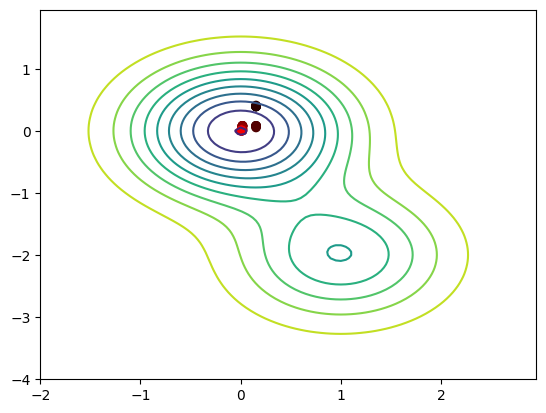

In [33]:
# Low mutation probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    mutation_probability=0.01,
)
genetic_algorithm.run()


Generation 0: Best solution = (0.26318670360313945, 0.3439045266466394), Objective value = 0.6698074059751986
Generation 1: Best solution = (0.26318670360313945, 0.3439045231545208), Objective value = 0.6698074039644631
Generation 2: Best solution = (0.26318670360313945, 0.028988147668293607), Objective value = 0.5629717428893464
Generation 3: Best solution = (0.26318670360313945, 0.028988147668293607), Objective value = 0.5629717428893464
Generation 4: Best solution = (-0.6729783211898805, -0.339923105599901), Objective value = 0.9316613312028391
Generation 5: Best solution = (-0.05556608315816902, 0.33126353483480386), Objective value = 0.6059755781578401
Generation 6: Best solution = (-0.4237869137261825, 0.308823860379718), Objective value = 0.7400844211699501
Generation 7: Best solution = (0.14318447383986665, 0.2961964035712299), Objective value = 0.6013513556880035
Generation 8: Best solution = (0.047455955844959874, 0.30882386041187004), Objective value = 0.5920334819510126
Gen

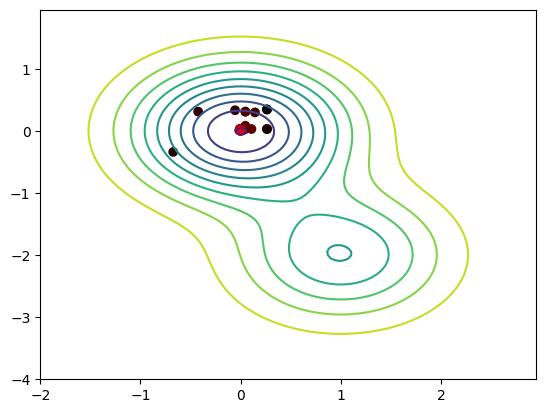

In [31]:
# High crossover probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    crossover_probability=0.95,
)
genetic_algorithm.run()


Generation 0: Best solution = (-0.7062259748090298, -1.0405031277409549), Objective value = 1.2834786141887407
Generation 1: Best solution = (0.21986731789426983, -2.6881442980146417), Objective value = 1.3298738251880793
Generation 2: Best solution = (-1.2780479172111683, 2.0226174337933074), Objective value = 1.4967346479023418
Generation 3: Best solution = (0.11418144444306932, 1.4011315988075523), Objective value = 1.3614039339702455
Generation 4: Best solution = (0.11418144444306932, 1.4009210368493399), Objective value = 1.3613221355539382
Generation 5: Best solution = (0.11418144444306932, 1.4011315995067406), Objective value = 1.361403934241804
Generation 6: Best solution = (-0.24092225118575783, -0.309670643227399), Objective value = 0.6365195701341347
Generation 7: Best solution = (-0.24092225118575783, -0.309670643227399), Objective value = 0.6365195701341347
Generation 8: Best solution = (0.114181439746325, -0.3096703515246517), Objective value = 0.5901082120414517
Generati

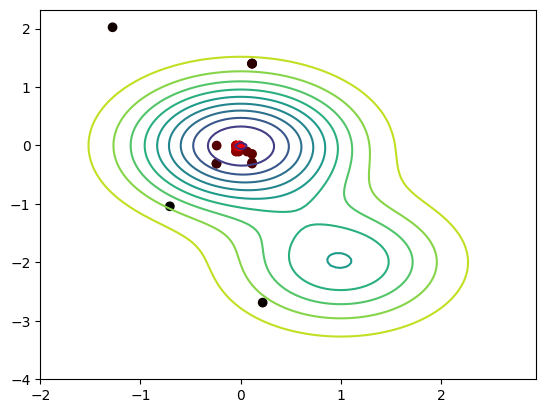

In [35]:
# High mutation probability

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=128,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50],
    mutation_probability=0.01,
)
genetic_algorithm.run()

Generation 0: Best solution = (-0.2155320398867815, 2.112611581597619), Objective value = 1.4889969336600546
Generation 1: Best solution = (1.430140915992098, -2.718394750896465), Objective value = 1.2519034711039188
Generation 2: Best solution = (0.7236535923278211, -2.8877698939497947), Objective value = 1.2892279622590084
Generation 3: Best solution = (0.7236535923278211, -2.8892957961394643), Objective value = 1.2897995824869928
Generation 4: Best solution = (0.7236535923278211, -2.8892957961394643), Objective value = 1.2897995824869928
Generation 5: Best solution = (0.8777685376627957, -1.8410009918364239), Objective value = 1.0041002702411355
Generation 6: Best solution = (0.8777685376627957, -1.8410009918364239), Objective value = 1.0041002702411355
Generation 7: Best solution = (-0.3826170548786507, -0.6919966430151803), Objective value = 0.951517268224331
Generation 8: Best solution = (0.08888312441348489, -0.42954146639200275), Objective value = 0.6565214809232761
Generation 

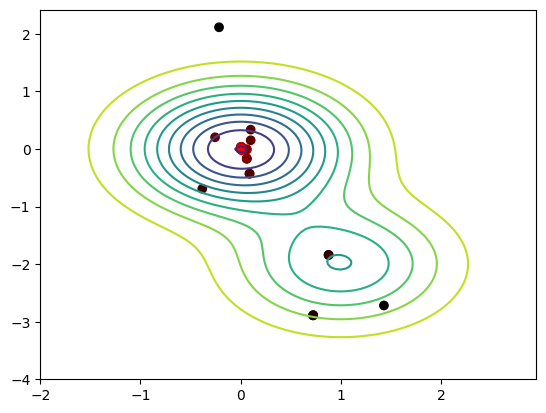

In [37]:
# Shorter chromosome length

genetic_algorithm = GeneticAlgorithm(
    chromosome_length=32,
    obj_func_num_args=2,
    objective_function=Function.f,
    aoi=[-50, 50]
)
genetic_algorithm.run()